In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import scipy
%matplotlib inline

import tensorflow as tf
from keras.applications import VGG19, InceptionV3
tfl = tf.keras.layers 

In [2]:
#Setting up parameters for images creation 

train_dir = 'celeb_faces_15k'
high_res = 64
low_res = 16

In [ ]:
#Codeblock only used when creating hi-res and low-res images for training purposes

for img in os.listdir( train_dir + '/org_images'):
    img_array = cv2.imread(train_dir + '/org_images/' + img)
    
    img_array = cv2.resize(img_array, (high_res, high_res))
    lr_img_array = cv2.resize(img_array,(low_res, low_res))
    cv2.imwrite(train_dir+ '/hr_images/' + img, img_array)
    cv2.imwrite(train_dir+ '/lr_images/' + img, lr_img_array)

## Model

Most of the hyperparameters are used from paper [1] only.

<img src = 'images_for_markdown/sr_gan.png' style = 'width:700px; height:400px;'>

In [3]:
#Residual and Upscaling blocks for building Generator Network

def res_block(inputs):
    
    residual = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(inputs)
    residual = tfl.BatchNormalization(momentum = 0.5)(residual)
    residual = tfl.PReLU(shared_axes = [1,2])(residual)
    
    residual = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(residual)
    residual = tfl.BatchNormalization(momentum = 0.5)(residual)
    
    return tfl.add([inputs, residual])

def upscaling(inputs):
    
    upscale_model = tfl.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(inputs)
    upscale_model = tfl.UpSampling2D(size = 2)(upscale_model)
    upscale_model = tfl.PReLU(shared_axes = [1,2])(upscale_model)
    
    return upscale_model

#Generator model

def create_generator(gen_inputs, num_res_block = 16):
    generator_model = tfl.Conv2D(filters = 64, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(gen_inputs)
    generator_model = tfl.PReLU(shared_axes = [1,2])(generator_model)

    skip_connect = generator_model

    for i in range(num_res_block):
        generator_model = res_block(generator_model)

    generator_model = tfl.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(generator_model)
    generator_model = tfl.BatchNormalization(momentum = 0.5)(generator_model)
    generator_model = tfl.add([generator_model, skip_connect])

    generator_model = upscaling(generator_model)
    generator_model = upscaling(generator_model)
    #generator_model = upscaling(generator_model)

    gen_outputs = tfl.Conv2D(filters = 3, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(generator_model)

    return tf.keras.Model(inputs = gen_inputs, outputs = gen_outputs)

In [4]:
#Discriminator block for building Discriminator Network

def discriminator_block(inputs, filters, strides = (1, 1), batchnorm = True):
    disc_model =  tfl.Conv2D(filters = filters, kernel_size = (3, 3), strides = strides, padding = 'same')(inputs)
    
    if batchnorm:
        disc_model = tfl.BatchNormalization(momentum = 0.8)(disc_model)

    disc_model = tfl.LeakyReLU(alpha = 0.2)(disc_model)

    return disc_model

#Discriminator Model

def create_discriminator(disc_inputs):
    filter_size_init = 64
    
    discriminator_model = discriminator_block(disc_inputs, filter_size_init, batchnorm = False)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*2)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*2, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*4)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*4, strides = (2, 2))
    
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*8)
    discriminator_model = discriminator_block(discriminator_model, filter_size_init*8, strides = (2, 2))

    discriminator_model = tfl.Flatten()(discriminator_model)
    discriminator_model = tfl.Dense(units = filter_size_init*16)(discriminator_model)
    discriminator_model = tfl.LeakyReLU(alpha = 0.2)(discriminator_model)

    discriminator_model = tfl.Dense(units = 1, activation = 'sigmoid')(discriminator_model)

    return tf.keras.Model(disc_inputs, discriminator_model)

In [5]:
#VGG-19 model using weights from imagenet to get features of different images later.

def build_vgg(input_shape):
    
    vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    
    return tf.keras.Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

In [6]:
#Combining all three parts of the model - Generator, Discriminator and VGG

def combined_model(generator_model, discriminator_model, vgg, lr_inputs, hr_inputs):
    
    gen_img = generator_model(lr_inputs)
    
    gen_features = vgg(gen_img)
    
    discriminator_model.trainable = False

    score = discriminator_model(gen_img)
    
    return tf.keras.Model(inputs = [lr_inputs, hr_inputs], outputs= [score, gen_features])


In [7]:
#Selecting the number of images for training and creating low-res and hi-res datasets from them

num_images = 10000

lr_list = os.listdir('celeb_faces_15k/lr_images')[:num_images]
lr_images = []

for img in lr_list:
    img_lr = cv2.imread('celeb_faces_15k/lr_images/' + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir('celeb_faces_15k/hr_images')[:num_images]
hr_images = []

for img in hr_list:
    img_hr = cv2.imread('celeb_faces_15k/hr_images/' + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

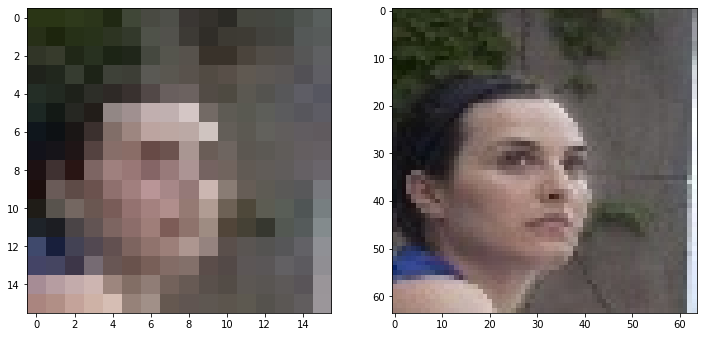

In [8]:
#Checking random images for consistency.

image_number = np.random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (low_res, low_res, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (high_res, high_res, 3)))
plt.show()

In [9]:
#Image Normalization

lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [10]:
#Train-test split

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size = 0.33, random_state = 42)

In [11]:
#Shape of the low-res and hi-res training images to be stored in keras Input.

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_inputs = tf.keras.Input(shape = lr_shape)
hr_inputs = tf.keras.Input(shape = hr_shape)

In [12]:
#Creating generator for GAN

generator = create_generator(lr_inputs)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 16, 16, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [13]:
#Creating discriminator for GAN

discriminator = create_discriminator(hr_inputs)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                           

In [14]:
#VGG-19 model to extract features

vgg = build_vgg((high_res, high_res, 3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [15]:
#Full GAN model used for this problem

gan_model = combined_model(generator, discriminator, vgg, lr_inputs, hr_inputs)

gan_model.compile(loss = ['binary_crossentropy', 'mse'], loss_weights = [1e-3, 1], optimizer = 'adam')
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 64, 64, 3)    2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 1)            13083457    ['model[0][0]']                  
                                                                                            

In [16]:
#Setting up batch size and dividing the training dataset into batches

batch_size = 32
train_lr_batches = []
train_hr_batches = []
for i in range(int(hr_train.shape[0] / batch_size)):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
#Training the model

epochs = 50

for e in range(epochs):
    
    # Setting up the labels for fake and real images
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size, 1))
    
    # Empty set for Generator and Discriminator losses, later used to calculate average of both losses
    g_losses = []
    d_losses = []
    
    batch_size_train = len(train_hr_batches)

    for b in tqdm(range(batch_size_train)):
        lr_images = train_lr_batches[b] 
        hr_images = train_hr_batches[b] 
        gen_images = generator.predict_on_batch(lr_images)

        # Training Discriminator using real and fake images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_images, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_images, real_label)
        
        # Training generator using low-res and high-res images with features taken from VGG-19.
        discriminator.trainable = False
        
        d_loss = np.add(d_loss_gen, d_loss_real) / 2
        
        image_features = vgg.predict(hr_images)
     
        g_loss, _, _ = gan_model.train_on_batch([lr_images, hr_images], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    if (e+1) % 5 == 0:
        generator.save('output/generated_e' + str(e+1) + '.h5')

1/1 [==============================] - 7s 7s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


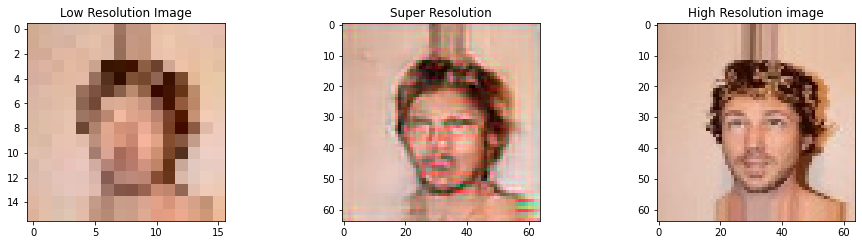

In [20]:
#Testing the performance of the model by selecting random image

from keras.models import load_model

generator = load_model('output/generated_e50.h5', compile=False)

img_id = np.random.randint(0, len(lr_test), 1)
inp_image = lr_test[img_id]
final_image = hr_test[img_id]
gen_image = generator.predict(inp_image)

#Plotting images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution Image')
plt.imshow(inp_image[0,:,:,:])
plt.subplot(232)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('High Resolution image')
plt.imshow(final_image[0,:,:,:])

plt.show()

### Sources

[1] "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" by Christian Ledig et al.